# Gillespie simulation

We can improve both the performance and statistical properties of simulations by changing the simulation approach we use. We *won't* try to optimise or improve the performance of synchronous dynamics, although there's certainly scope to do so: instead, we'll *replace* the synchronous approach with another technique that (it turns out) is better-suited to the accurate simulating large systems.

The technique we use is sometimes called *Gillespie's stochastic siumulation algorithm* or simply *Gillespie simulation*, It was developed initially {cite}`Gil76,Gil77` to perform *ab initio* chemical simulations, where a lot of molecules react according to a set of simple chemical rules &ndash; a situation that's very similar to a process over a network. Cao *et alia* {cite}`TauLeaping` provide a very accessible description to the basic mathematics of the technique, which we'll develop in a network context below.

The essence of Gillespie simulation is the observation that we can manipulate the probabilities governing events. Instead of testing in every discrete timestep which of the available events can occur (for example from susceptible to infected in SIR), we predict the instant of time at which the next event will occur &ndash; skipping the intermediate time when nothing happens. To put this another way, we convert the probabilities of individual events in *space* into aggregate probability distributions of events over *time*. If the simulation is such that a lot of "empty" timesteps occur, then this approach will avoid the costs of simulating them. It has the additional advantage of operating in continuous time with only a single event happening at each instant, which solves the problem of events affecting each other within a timestep. 

Unfortunately these benefits come at the cost of some fairly subtle mathematics needed to manipulate the probability distributions into the required form. We'll deal with this first, and then encode the result as a new simulation dynamics that we can use to simulate epidemics using the *same* compartmented process models as we used for the synchronous case.

## From single-step to interval behaviour

In the synchronous simulation we took all the places at which an event could occur and probabilistically chose some of them for firing. Infection happens along SI edges. (We can also identify SS, SR, II, and RR edges, and these play important r&ocirc;les in some epidemic models, although not in SIR.) SIR assumes that the dynamics occurs at these loci independently. If we denote the probability of an SI edge transmitting an infection as $\beta$ as usual, then the rate at which edges in the network transmit infection is given by $\beta [SI]$ where $[SI]$ denotes the number of SI edges in the network (the size of the locus, in other words). $[SI]$ is of course a function of time, since the population of SI edges is changed by the infection event. Similarly if infected nodes are removed with probability $\alpha$ the rate of recovery is given by $\alpha [I]$. In a sense the values of $[SI]$ and $[I]$ constitute the "state" of the dynamical system. Each infection event will decrease $[SI]$ by one and increase $[I]$ by a value that depends on the degree of the newly-infected node and how many of those adjacent nodes are susceptible. This indicates that the dynamics entwines three distinct features:

1. the probabilities of different events;
1. the number of places at which these events can occur; and
1. the topology of the network that controls how the populations of different loci evolve.

It is this third feature that distinguishes the network formulation from the differential equation formulation, since it allows heterogeneity of evolution in both space and time.

### The joint event probability distribution

Let us re-formulate the above in a way that's more explcitly continuous in nature. The probability that some SI edge will transmit infection in a small time $dt$ is given by $a_I \, dt = \alpha [SI] \, dt$, and recovery similarly by $a_R \, dt = \beta [I] \, dt$. We can now ask two questions: given the state of the network,

1. when will the next event occur?, and
1. what event will it be?

Clearly these are probabilistic questions, so the answers will be formulated as probability distributions. Let's define a probability distribution $P(\tau, e) \, d\tau$ as the probability that an event will happen in the interval $(t + \tau, t + \tau + d\tau)$ *and* that that event will be of type $e$, which for SIR will be either an infection ($I$) or a recovery ($R$) event. So at time $t$ we're looking at the distribution of the times $\tau$ between $t$ and the next event, and the identity of that event. This is a joint probability density function on the space of $\tau$ and $e$, where $\tau$ is a continuous random variable and $e$ is a discrete random variable. We an then draw values a pair of values  $(\tau, e)$ from this distribution to give us the time to the next event and its identity. 

Note also that the value of $\tau$ answers the first question above, while the value of $e$ answers the second.

What do we expect from this distribution? Intuitively, a system where there are lots of places where events can occur should give rise to a high likelihood of drawing a small value of $\tau$ from the distribution: the events happen close together in time. Conversely, as the number of places available decreases, it becomes more likely that we'll draw a larger value of $\tau$.

### The distribution of events in time

We now need a way to specify $P(\tau, e)$ and to draw values from it.

Let's think about $P(\tau, e) \, d\tau$ a little more. We're looking for a value of $\tau$ at which the next event happens, and the identity of that event. Equivalently, we could say that we want the probability that *no* event happens in the interval $[t, t + \tau]$, *and* that an $e$ event happens in the interval $[t + \tau, t + \tau + d\tau]$. The use of the word "and" here suggests that we'll be multiplying together the probabilities of the two components. We defined to probability of a particular event happening above, so we can then re-phrase $P(\tau, e) \, d\tau$ a little differently

$$
    P(\tau, e) \, d\tau = P_0(\tau) \, a_e \, d\tau
$$

where $P_0(\tau)$ is the probability of no event happening in $(t + \tau)$ and $a_e$ is the probability of *some* event $e$ happening in an interval $d\tau$. Since we already know the values of $a_e$ from the model parameters $\alpha$ and $\beta$ and the size of the appropriate loci $[SI]$ and $[I]$, we just need an expression for $P_0(\tau)$. Let $a \, d\tau' = \sum_e a_e \, d\tau'$ be the probability that *some* event happens in an interval $d\tau'$, simply by summing-up the component probabilities of the different events. We then have

$$
    P_0(\tau' + d\tau') = P_0(\tau') \, (a \, d\tau')
$$

which is the probability that no event occurs in in the interval $(t, t + \tau)$ *and then* that one occured in the following interval $d\tau'$. This is a differential equation, the solution of which is

$$
    P_0(\tau) = e^{-a \tau}
$$

Substituting back into the above we therefore have

$$
    P(\tau, e) = P_0(\tau) \, a_e
               = a_e \, e^{-a \tau}
$$

This is our joint probability distribution for the events defined by the various values of $a_e$. These values are *rates*, not probabilities: they are defined in terms of the number of places at which each event $e$ can occur. 

### Drawing from the distribution

To conduct simulation, we need to be able to draw a pair $(\tau, e)$ from our distribution. However, we can't simply choose $\tau$ and $e$ independently of each other, because the value of $P(\tau, e)$ depends on *all* the possible events $e$ because of the presence of $a$, the sum of all event rates, in its definition. That means that the time to the next event depends on the number of events that could occur.

In other words, $P(\tau, e)$ is a **joint probability distribution** from which we need to draw a pair. Any joint probability distribution $P(a, b)$ can be re-written as $P(a, b) = P(a) \, P(b | a)$: the prior (independent) probability of $a$ occuring multiplied by the probability of $b$ occurring *given that* $a$ has occurred. In our case

$$
    P(\tau, e) = P(\tau) \, P(e | \tau)
$$

where $P(\tau)$ is the probability that *some* event will occur on the interval $(t, t + \tau)$ and $P(e | \tau)$ is the probability that this event will be of type $e$ *given that* it occurs on this interval. Clearly $P(\tau)$ is simply the sum of the probabilities for all the events that may occur

$$
    P(\tau) = \sum_e P(\tau, e)
$$

and therefore

$$
    P(e | \tau) = \frac{P(\tau, e)}{\sum_{e'} P(\tau, e')}
$$

These two equations are both single-variable probability distributions (over $\tau$ and $e$ respectively) expressed in terms of the joint probability distribution $P(\tau, e)$, and if we substitute for $P(\tau, e)$ from above we get

$$
\begin{align*}
    P(\tau)     &= \sum_e a_e e^{-a \tau} \\
                &= a e^{-a \tau} \\
    P(e | \tau) &= \frac{P(\tau, e)}{\sum_{e'} P(\tau, e')} \\
                &= \frac{a_e e^{-a \tau}}{a e^{-a \tau} } \\
                &= \frac{a_e}{a}
\end{align*}
$$

Note that $P(e | \tau)$ is in this case independent of $\tau$, since the event probabilities are constants.

Let's briefly return to the network scenario we're interested in. The value $\tau$ is the interval of time until the next event occurs in the network, whether that is the infection of the S node attached to an SI edge of the recovery of an I node. Which of these events happens is determined by $e$. The pair $(\tau, e)$ therefore fully defines the time and identity of the next event in the simulation. It remains to see how we choose these two values, and how the network evolves in response to the selected event.

### <span id="sec_epidemic_gillespie_drawing_pair"></span> Generating the $(\tau, e)$ pair

In order to make use of $P(\tau, e)$ we have to be able to draw $\tau$ and $e$ from the joint distribution. We saw above that we can dop this by drawing values from $P(\tau)$ and $P(e | \tau)$ individually, with the latter distribution actually being independent of time in our current case.

It may not be obvious how to draw from such distributions, but we can manipulate the probabilities to make it possible using only a source of uniformly-distributed random numbers on the range $(0, 1)$. The trick is to observe that, for any probability density function $P(a)$, the value $P(a) \, da$ represents the probability that a value drawn from the distribution will lie between $a$ and $(a + da)$. From this we can construct a cumulative distribution function,

$$
    F(x) = \int_{-\infty}^{x} P(a) \, da
$$

where $F(x_0)$ represents the probability that a value drawn from $P(a)$ is less than or equal to $x_0$, also denoted $P(a \le x_0)$. If we now draw a value $r$ from a uniform distribution on $(0, 1)$ we can compute $x = F^{-1}(r)$ where $F^{-1}$ is the inverse of the cumulative distribution function and $x$ will be distributed according to $P(a)$.  This means we can convert a uniformly-distributed value into a value drawn from any probability distribution for which we can construct (and invert) a cumulative distribution function.

In our case we have that $P(\tau) = a \, e^{-a \tau}$. Remember that $a$ is a constant, and that intervals can't be negative. This means that

\begin{align*}
    F(\tau) &= \int_{-\infty}^{\tau} a \, e^{-a \tau'} \, d\tau' \\
            &= \int_0^{\tau} a \, e^{-a \tau'} \, d\tau' \\
            &= -e^{-a \tau'} \, \bigg|_0^\tau \\
            &= -e^{-a \tau} -(-e^0) \\
            &= 1 - e^{-a \tau}
\end{align*}

This is an awkward expression to manipulate, but we can observe that, if a number $r_1$ is uniformly distributed, then so by definition is $1 - r_1$, so if we set $F(\tau) = 1 - r_1$ we can cancel-out the constant ones and get a simpler expression overall. We then have

\begin{align*}
      1 - r_1 &= F(\tau) \\
              &= 1 - e^{-a \tau} \\
          r_1 &= e^{-a \tau} \\
              &= \frac{1}{e^{a \tau}} \\
   e^{a \tau} &= \frac{1}{r_1} \\
       a \tau &= \ln \frac{1}{r_1} \\
         \tau &= \frac{1}{a} \, \ln \frac{1}{r_1}
\end{align*}

The discrete case works similarly. If we draw a value $r_2$ on $(0, 1)$, then the value of $e$ we require is given by $\sum_{e' = 0}^{e - 1} a_{e'} \leq r_2 a \leq \sum_{e' = 0}^{e} a_{e'}$: the largest $e$ such that the sum of $a_{e'}$ for $e' \le e$ is less than $r_2 a$.

The upshot of all this probability theory is that we can choose a time to the next event $\tau$ and the identity of the next event $e$ from the distribution induced by the individual event probabilities and the size of the loci for the various events in the network, by drawing two uniformly-distributed numbers and performing two simple calculations {cite}`Gil76`.  

## Stochastic dynamics

All we now have to do is to take the simple calculations above and implement them as a sub-class of `epydemic.Dynamics`, exactly as we previously did for discrete-time synchronous dynamics. 

In [14]:
import numpy
import math
from epyc import Experiment
from epydemic import Dynamics, SIR, ERNetwork

import pandas as pd

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'
matplotlib.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt
import seaborn
matplotlib.style.use('seaborn')
seaborn.set_context('notebook', font_scale=0.75)

We'll start with the stochastic dynamics class itself:

In [4]:
class StochasticDynamics(Dynamics):
    '''A dynamics that runs stochastically in continuous time. This is a
    very efficient and statistically exact approach, but requires that the
    statistical properties of the events making up the process are known.
    
    :param p: the process to run
    :param g: network or network generator (optional, can be provided later)'''

    
    def __init__(self, p, g = None):
        super().__init__(p, g)

    def do(self, params):
        '''Run the process using Gillespie dynamics.

        :param params: the experimental parameters
        :returns: the experimental results dict'''
        proc = self.process()
        rng = numpy.random.default_rng()
        t = 0
        events = 0
        while not proc.atEquilibrium(t):
            # pull the transition dynamics at this timestep
            transitions = self.eventRateDistribution(t)

            # compute the total rate of transitions for the entire network
            a = 0.0
            for (_, r, _) in transitions:
                a += r
            if a == 0.0:
                break              # no events with non-zero rates

            # calculate the timestep delta
            r1 = rng.random()
            dt = (1.0 / a) * math.log(1.0 / r1)

            # calculate which event happens
            (l, _, ef) = transitions[0]
            if len(transitions) > 1:
                # choose the rate threshold
                r2 = rng.random()
                xc = r2 * a

                # find the largest event for which the cumulative rates
                # are less than the random threshold
                xs = 0
                for v in range(0, len(transitions)):
                    (l, xsp, ef) = transitions[v]
                    if (xs + xsp) > xc:
                        break
                    else:
                        xs += xsp

            # increment the time
            t += dt
            self.setCurrentSimulationTime(t)

            # fire any events posted for at or before this time
            events = events + self.runPendingEvents(t)

            # it's possible that posted events have removed all elements
            # from the chosen locus, in which case we simply continue
            # with the next event selection
            # sd: is this correct? or does it mess up the statistics too much?
            if len(l) > 0:
                # draw a random element from the chosen locus
                e = l.draw()

                # perform the event by calling the event function,
                # passing the dynamics, event time, network, and element
                ef(t, e)

                # increment the event counter
                events += 1

        # when we get here there may still be posted events that haven't
        # been run, and these are ignored: equilibrium overrides posting

        # add some more metadata
        (self.metadata())[self.TIME] = t
        (self.metadata())[self.EVENTS] = events

        # report results
        rc = self.experimentalResults()
        return rc

We need an event rate distribution rather than an event probability distribution so we provide that as a method `eventRateDistribution()` that takes the probability distribution returned by `eventDistribution()` and, for each event, multiplies the probability of that event happening by the number of places the event can happen. 

The important part of the class is the `do()` method, which implements the mechanism for drawing the $(\tau, e)$ pair as described [above](#sec_epidemic_gillespie_drawing_pair). In the code, `dt` is the interval to the next event ($\tau$), while `xc` is used to choose the event that occurs.

## <span id="sec_epidemic_stochastic_example"></span> Simulating SIR (again)

We can now take the same parameters as we used in the [synchronous case](epidemic-synchronous.ipynb#sec_epidemic_synchronous_example):

In [7]:
params = dict()

# ER network parameters
params[ERNetwork.N] = 5000
params[ERNetwork.KMEAN] = 10

# SIR parameters
params[SIR.P_INFECTED] = 0.01
params[SIR.P_INFECT] = 0.2
params[SIR.P_REMOVE] = 0.1

Plugging these parameters into our new simulation class, we get:

In [12]:
m = SIR()
sim = StochasticDynamics(m, ERNetwork())

sto = sim.set(params).run()

In [15]:
sto[Experiment.RESULTS]

{'epydemic.SIR.S': 5, 'epydemic.SIR.I': 0, 'epydemic.SIR.R': 4995}

What do we get? We can look at several of the same factors that we looked at for the synchronous case. Firstly, the size of epidemic should be the same, given that the simulation parameters were identical, with the proviso that both simulations have a large amount of randomness in them that will preclude identical results: 

In [18]:
Rs = sto[Experiment.RESULTS][SIR.REMOVED]
N = params[ERNetwork.N]
print('Epidemic covered {percent:.2f}% of the network'.format(percent = (Rs / N) * 100))

Epidemic covered 99.90% of the network


We can at least say that both simulations have produced an epidemic (or some size) for these parameter values. That's important in terms of some weak notion of correctness, but of course these two approaches are *supposed* to behave the same, for a suitably stochastic definition of "the same".

## Comparison

We can of course dig-into the results in more detail. There are a lot of potentially interesting things to explore, and we'll just pick two of the most important: is one method faster than the other?, and, do they look like they generate a similar train of events?

First we load both datasets:

In [8]:
with open('sync.pickle', 'rb') as handle:
    syn = pickle.load(handle)
with open('sto.pickle', 'rb') as handle:
    sto = pickle.load(handle)

### Performance

Probably the most important measure of performace is "wallclock time", the time that elapsed while the simulationn ran: 

In [9]:
print "Elapsed simulation times:"
print "Synchronous {elapsed:.2f}s".format(elapsed = syn[epyc.Experiment.METADATA]['elapsed_time'])
print "Stochastic  {elapsed:.2f}s".format(elapsed = sto[epyc.Experiment.METADATA]['elapsed_time'])

Elapsed simulation times:
Synchronous 0.46s
Stochastic  1.13s


Where is the time difference coming from? Thge synchronous simulation simulated a lot of timesteps where nothing happened: there were no events, just from the random nature of the process and the rates of events. The stochastic simulation jumped over these empty periods and only did work when there was work to do. That's clearly a benefit, and one can imagine that, for larger simulations and those whose events are less frequent, it might become a really significant computational saving.

### Equivalence

But a performance benefit is only useful if the results are correct: there's no point in doing the wrong things faster, after all. So we need to convince ourselves that, at the very least, the two simulations conducted for the same parameters produce plausibly comparable results &ndash; even while we accept that statistical variations might occur.

We can start by looking at the populations of the different compartments at equilibrium:

In [10]:
print "Node type sub-populations:"
print "Synchronous:", syn[epyc.Experiment.RESULTS]['compartments']
print "Stochastic:", sto[epyc.Experiment.RESULTS]['compartments']

Node type sub-populations:
Synchronous: {'I': 0, 'S': 227, 'R': 4773}
Stochastic: {'I': 0, 'S': 227, 'R': 4773}


Although we are using two different simulation techniques, we claim that they are "the same" in the sense of simulating the same process dynamics. One way to test this is to look at the distance between successive events. If the events are happening with similar distributions, we would expect the inter-event time distributins to be similar too.

To do this we need to capture when (in simulation time) each event occurs. We can do this quite simply, either by extending the simulation dynamics classes, or &ndash; more straightforwardly &ndash; by defining a new compartment5ed model whose results include the simulation times for events:

In [11]:
class SIR_EventDistribution(epydemic.SIR):
    '''An SIR model that also captures the times of all events.'''
    
    def __init__( self ):
        super(SIR_EventDistribution, self).__init__()
        
        # create a place to store the sequence of event times
        self._eventDistribution = []
        
    def reset( self ):
        super(SIR_EventDistribution, self).reset()
        self._eventDistribution = []

    def results( self, g ):
        rc = super(SIR_EventDistribution, self).results(g)
        
        # add the event times to the results
        rc['event_times'] = self._eventDistribution
        
        return rc

    def infect( self, dyn, t, g, (n, m) ):
        # perform the base event
        super(SIR_EventDistribution, self).infect(dyn, t, g, (n, m))
        
        # record the event time
        self._eventDistribution.append(t)
        
    def remove( self, dyn, t, g, n ):
        # perform the base event
        super(SIR_EventDistribution, self).remove(dyn, t, g, n)
        
        # record the event time
        self._eventDistribution.append(t)
        

We can now run the same process with different dynamics, and capture the event trains that are generated. For clarity we'll run a slightly larger epidemic so we get more events to compare:

In [31]:
# epidemic parameters
params = dict()
params[epydemic.SIR.P_INFECTED] = pInfected
params[epydemic.SIR.P_INFECT] = 0.05
params[epydemic.SIR.P_REMOVE] = 0.01
m = SIR_EventDistribution()

# run process over a larger ER network
g = networkx.erdos_renyi_graph(30000, 5.0 / 30000)

# synchronous dynamics
sim = epydemic.CompartmentedSynchronousDynamics(m, g)
syn_res = sim.set(params).run()
syn_events = syn_res[epyc.Experiment.RESULTS]['event_times']

# stochastic dynamics
sim = CompartmentedStochasticDynamics(m, g)
sto_res = sim.set(params).run()
sto_events = sto_res[epyc.Experiment.RESULTS]['event_times']

We can now compute the inter-event times. Since we're working with continuous and discrete time depending on the dynamics, histogramming the intervals should generate similar curves: 

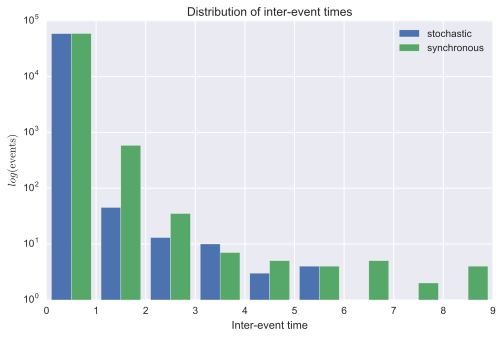

In [40]:
fig = plt.figure(figsize = (8, 5))
plt.title('Distribution of inter-event times')
plt.xlabel('Inter-event time')
plt.ylabel('$log(\mathrm{events})$')

# work out inter-event times
l = 0
syn_inter = []
for i in xrange(1, len(syn_events) - 1):
    syn_inter.append(syn_events[i] - l)
    l = syn_events[i]
sto_inter = []
l = 0
for i in xrange(1, len(sto_events) - 1):
    sto_inter.append(sto_events[i] - l)
    l = sto_events[i]

# plot the histogram of the distribution
plt.hist([sto_inter, syn_inter],
         bins = range(10),
         log = True,
         label = ['stochastic', 'synchronous'])

plt.legend()
_ = plt.show()

So those are *similar*, both dropping off exponentially as we'd expect. They don't follow exactly the same distribution, but that could just be the result of the stochastic nature of the process: we ran the two dynamics over the same network, but from different initial (random) seedings of nodes. Or it could be because the synchronous approach is less exact because of interactions between events. If we wanted a closer look, we'd have to perform some repetitions to see whether we got different results repeatedly or whether things evened out &ndash; but that's something for another time.